## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Carga datos y representa la serie

In [5]:
df = pd.read_csv('data/AirPassengers.csv', index_col='date', parse_dates=True)
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


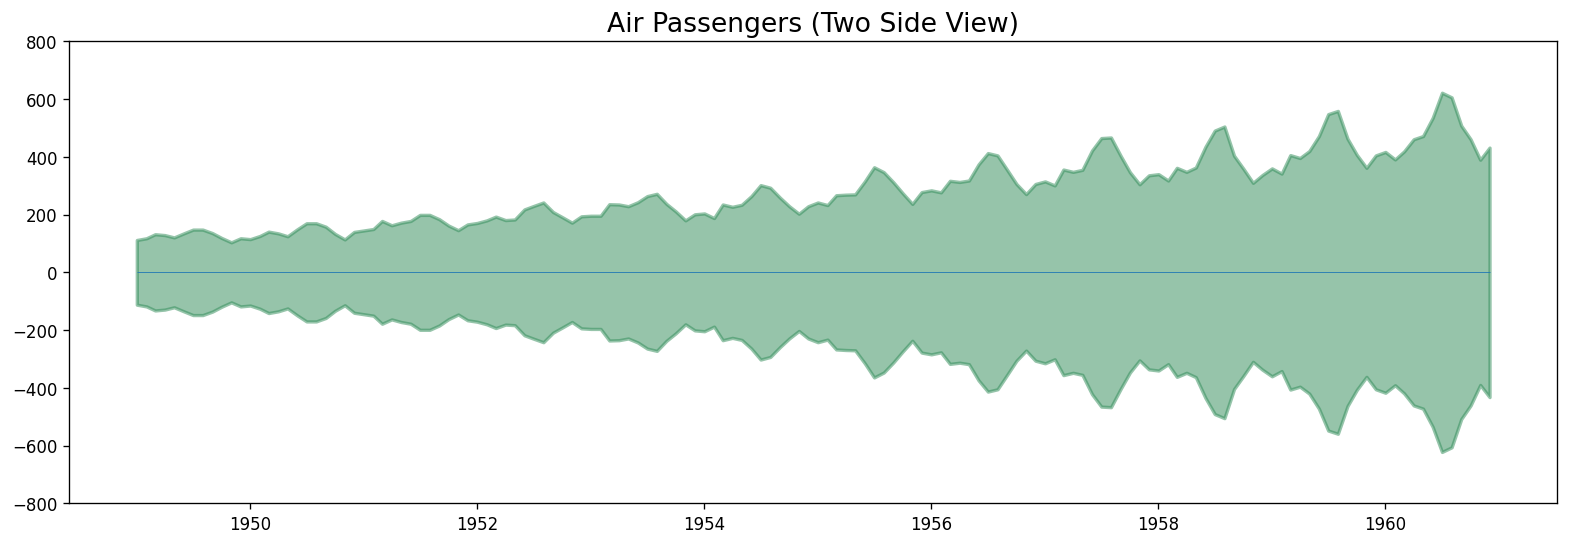

In [8]:
x = df.index
y1 = df['value'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

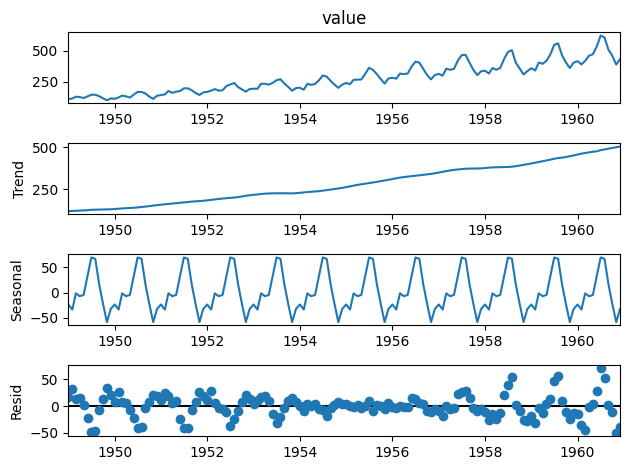

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')
seasonal = result_add.seasonal

result_add.plot();

# Parece que la tendencia se repite cada año, por tanto habría estacionalidad

In [19]:
# Calcular las diferencias entre los valores en períodos consecutivos
differences = df['value'].diff()

# Calcular la autocorrelación de las diferencias
autocorrelation = differences.autocorr()

# Obtener el valor de estacionalidad a partir de la inversa de la autocorrelación
estacionalidad = round(1 / autocorrelation)

print("El valor de estacionalidad es:", estacionalidad)

El valor de estacionalidad es: 3


## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

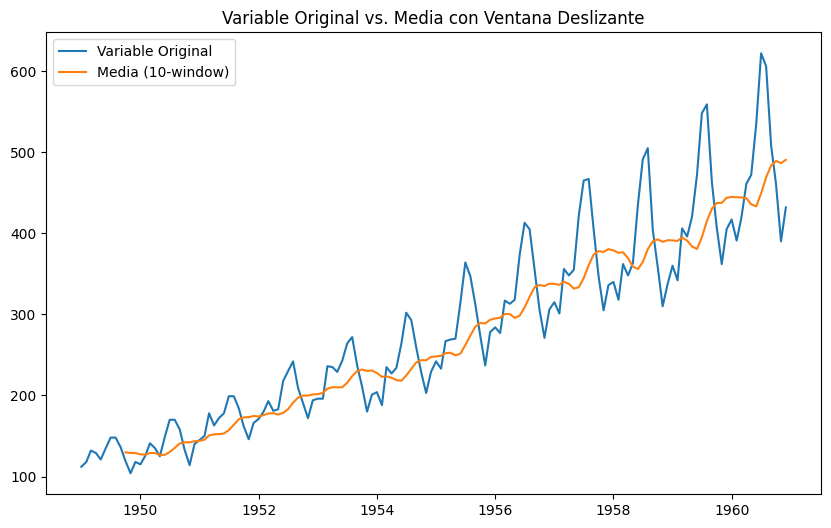

In [21]:
# Calcular la media mediante una ventana deslizante
window_size = 10  # Tamaño de la ventana
rolling_mean = df['value'].rolling(window=window_size).mean()

# Graficar la variable original y su media obtenida mediante una ventana deslizante
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['value'], label='Variable Original')
ax.plot(rolling_mean, label=f'Media ({window_size}-window)')

ax.legend()
ax.set_title('Variable Original vs. Media con Ventana Deslizante')
plt.show()

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['value'])
p_value = result[1]

if p_value < 0.05:
    print("La serie temporal es estacionaria")
else:
    print("La serie temporal no es estacionaria")

print(p_value)

La serie temporal no es estacionaria
0.991880243437641


## 4. Aplica una transformación logarítmica

In [25]:
df_log = np.log(df)

## 5. Divide en train y test. Guarda 20 muestras para test.

In [27]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_log, test_size=20, random_state=42)
test_df.to_csv('data/test_data.csv')

## 6. Crea tu primer modelo ARIMA

In [32]:
from pmdarima.arima import ARIMA

model_ar = ARIMA(order=(1,0,0))
model_ar.fit(train_df)

c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo

ARIMA(order=(1, 0, 0))

In [36]:
from sklearn.metrics import mean_squared_error

predictions = model_ar.predict(20)
print("root_mean_squared_error:", np.sqrt(mean_squared_error(test_df, predictions)))

root_mean_squared_error: 0.34860387701088813


c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 7. Representa en una gráfica los datos de test y tus predicciones.

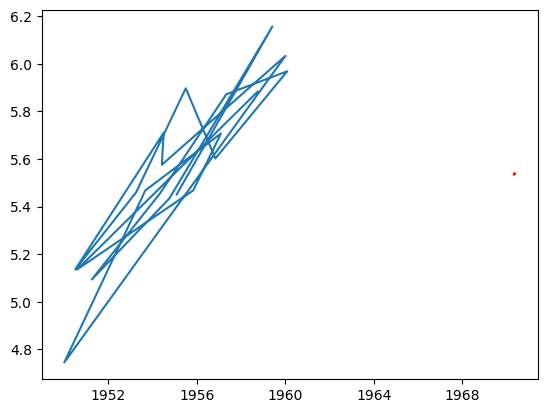

In [38]:
plt.plot(test_df)
plt.plot(predictions,color='red');

## 8. Prueba otros modelos, a ver qué performance presentan.

In [40]:
#Moving Average
model_ma = ARIMA(order = (0,0,1))
model_ma.fit(train_df)
predictions = model_ma.predict(20)
print("mean_squared_error:", mean_squared_error(test_df, predictions))

mean_squared_error: 0.1215359190127447


c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo

In [42]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train_df)
        results.append((param,model_arima_fit.aic()))
    except:
        continue

c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo

In [43]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

,ARIMA params,AIC
0,"(0, 0, 0)",159.496764
1,"(0, 0, 1)",161.491659
25,"(1, 0, 0)",161.492650
6,"(0, 1, 1)",161.872486
2,"(0, 0, 2)",162.485831


In [45]:
best_model = ARIMA(order=(0,0,0))
best_model.fit(train_df)
predictions = best_model.predict(20)
print("mean_squared_error:", mean_squared_error(test_df, predictions))

mean_squared_error: 0.12138567943288026


c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\crist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not mo